## Identifying fusulinids with Convolutional Neural Network (CNN)
@author: **Meng Chen**            
[School of Earth Sciences](https://www.nju.edu.cn/EN/7f/80/c7136a163712/page.psp)                                  
[Centre of Research and Education of Biological Evolution and Environment](https://es.nju.edu.cn/crebee/)                                    
[Nanjing University](https://www.nju.edu.cn/EN/)

### Overview
This project focus on how to identify the microorganism fusulinids with machine learning techniques. We implemented the CNN on the images of the fusulinids to classify it genus and even species.

### Data
The data was provided by Dr. Yukun Shi, Deputy Director of the Centre of Research and Eduction of Biological Evolution and Environment, Nanjing University. All images have been previously preprocessed and you can find some of the examples in the example folder.

### Data augumentation
The original dataset only has 119 images of five genus, which are far from enough for deep learning neural network. To alliviate the issue, I used `ImageDataGenerator` in `keras.preprocessing.image` to perform the data augmentation.

### Model
CNN model was implemented with Keras API (Tensorflow backend).

### Train the model

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Conv2D, Reshape, MaxPooling2D, Activation, Dropout
from keras import Sequential, Model
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
print('Numpy version: ', np.__version__)
print('Keras version: ', keras.__version__)
print('TensorFlow version: ', tf.__version__)

Numpy version:  1.16.5
Keras version:  2.3.1
TensorFlow version:  2.0.0


#### Create image_generator using `ImageDataGenerator`

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#### Input all images 

In [4]:
path = "augumented"
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('The augmented data has {} images.'.format(image_count))
# genus_names
GENUS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != '.DS_Store'])
print('The fusulinids genus includes', GENUS_NAMES)

The augmented data has 6928 images.
The fusulinids genus includes ['Pseudoschwagerina' 'Robustoschwgerina' 'Sphaeroschwgerina' 'Triticites'
 'Verbeekina' 'Zellia']


#### Some species in Triticites for example

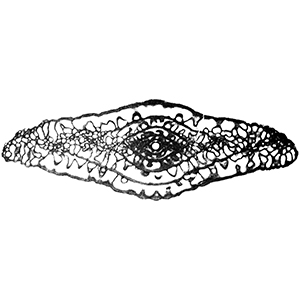

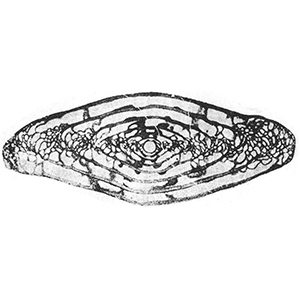

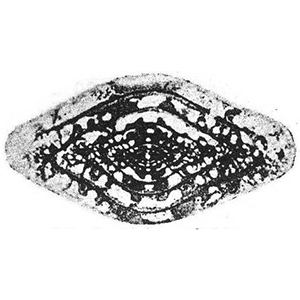

In [5]:
Triticites = list(data_dir.glob('Triticites/*'))
for species in Triticites[:3]:
    display.display(Image.open(str(species)))

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 255
IMG_WIDTH = 255
STEP_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
train_generator = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    classes = list(GENUS_NAMES)
)

Found 6928 images belonging to 6 classes.


In [7]:
print(dir(train_generator))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filepaths', '_flow_index', '_get_batches_of_transformed_samples', '_keras_api_names', '_keras_api_names_v1', '_set_index_array', 'allowed_class_modes', 'batch_index', 'batch_size', 'class_indices', 'class_mode', 'classes', 'color_mode', 'data_format', 'directory', 'dtype', 'filenames', 'filepaths', 'image_data_generator', 'image_shape', 'index_array', 'index_generator', 'interpolation', 'labels', 'lock', 'n', 'next', 'num_classes', 'on_epoch_end', 'reset', 'sample_weight', 'samples', 'save_format', 'save_prefix', 'save_to_dir', 'seed', 'set_processing_attrs', 'shuffle', 'split', 'subset', 'target

In [8]:
list(train_generator.class_indices.keys())

['Pseudoschwagerina',
 'Robustoschwgerina',
 'Sphaeroschwgerina',
 'Triticites',
 'Verbeekina',
 'Zellia']

In [9]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(GENUS_NAMES[np.int(label_batch[n])])
        plt.axis('off')

The shape of the data is (32, 255, 255, 3)


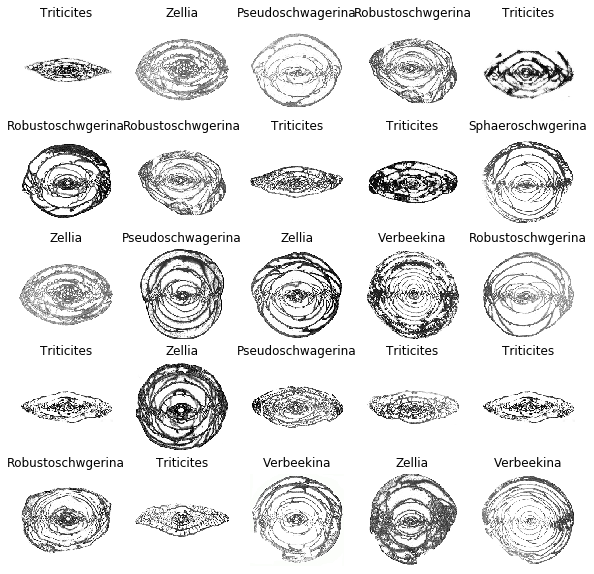

In [10]:
image_batch, label_batch = next(train_generator)
print('The shape of the data is', image_batch.shape)
show_batch(image_batch, label_batch)

In [11]:
path = 'your direcotry'
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
valid_generator = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=1,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    classes = list(GENUS_NAMES)
)

Found 0 images belonging to 6 classes.


In [12]:
def build_cnn(input_size=(255, 255, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(128, 3, activation='relu')(inputs)
    conv1 = Conv2D(128, 3, activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)
    flat1 = Flatten()(pool1)
    relu1 = Activation('relu')(flat1)
    drop1 = Dropout(rate=0.5)(relu1)
    dense1 = Dense(64, activation='relu')(drop1)
    dense2 = Dense(6, activation='softmax')(dense1)
    model = Model(inputs=inputs, outputs=dense2)
    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [13]:
model = build_cnn()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 128)     3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 251, 251, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 492032)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 492032)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 492032)            0   

In [14]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    epochs=50,
    verbose=1
)

Epoch 1/50
216/216 [==============================] - 48s 220ms/step - loss: 0.5494 - accuracy: 0.9334
Epoch 2/50
216/216 [==============================] - 39s 182ms/step - loss: 0.0368 - accuracy: 0.9840
Epoch 3/50
216/216 [==============================] - 40s 184ms/step - loss: 0.0354 - accuracy: 0.9838
Epoch 4/50
216/216 [==============================] - 40s 184ms/step - loss: 0.0328 - accuracy: 0.9833
Epoch 5/50
216/216 [==============================] - 39s 181ms/step - loss: 0.0334 - accuracy: 0.9819
Epoch 6/50
216/216 [==============================] - 39s 182ms/step - loss: 0.0313 - accuracy: 0.9845
Epoch 7/50
216/216 [==============================] - 39s 181ms/step - loss: 0.0322 - accuracy: 0.9830
Epoch 8/50
216/216 [==============================] - 39s 182ms/step - loss: 0.0274 - accuracy: 0.9856
Epoch 9/50
216/216 [==============================] - 39s 182ms/step - loss: 0.0274 - accuracy: 0.9859
Epoch 10/50
216/216 [==============================] - 39s 182ms/step - l

In [16]:
def plot_history(history):
    '''plot the history of the cnn model'''
    history_dict = history.history
    acc = history_dict['accuracy']
    #val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    #val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    figs, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].plot(epochs, loss, 'bo', label='Training loss')
    #axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axes[0].set_title('Training and validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    # plot accuracy again epoch
    axes[1].plot(epochs, acc, 'bo', label='Training acc')
    #axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
    axes[1].set_title('Training and validation accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

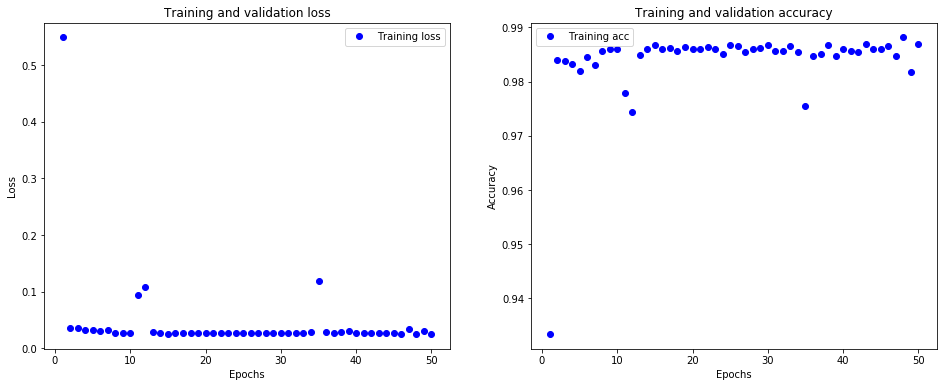

In [17]:
plot_history(history)

In [20]:
model.save('model/id_fusulinids.h5')